In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import marimo as mo

In [ ]:
def detect_dot_grid(image_path, rows=21, cols=17) -> (list, np.ndarray):
    """
    Detects a grid of dots in the given image and returns their coordinates.

    Args:
        image_path (str): Path to the input image.
        rows (int): Number of rows in the grid.
        cols (int): Number of columns in the grid.

    Returns:
        structured_grid (list): A list of lists containing the coordinates of the dots in a structured grid format.
        output_img (np.ndarray): The image with detected dots highlighted.
    """

    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 2. Thresholding: Dots are bright, background is black
    # Using a fixed threshold or Otsu's. 50 is a safe threshold for this image.
    _, thresh = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)

    # 3. Find connected components (blobs)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
        thresh
    )

    # 4. Filter dots by area to remove single pixels or large noise
    # The grid dots are roughly 5-20 pixels in area.
    candidate_dots = []
    for i in range(1, num_labels):
        area = stats[i, cv2.CC_STAT_AREA]
        if 1 <= area <= 150:
            candidate_dots.append(centroids[i])

    # 5. Filter outliers
    # We expect rows * cols = 357 dots. If we found more, we remove the most distant ones.
    # In this specific image, noise dots are at the top (low Y).
    candidate_dots.sort(key=lambda p: p[1])  # Sort by Y coordinate

    # If there are outliers at the top, there will be a large gap in Y
    y_coords = [p[1] for p in candidate_dots]
    y_gaps = np.diff(y_coords)
    max_gap_idx = np.argmax(y_gaps)

    # Check if the largest gap indicates noise at the top or bottom
    # Usually, the grid dots are very close together vertically.
    if len(candidate_dots) > rows * cols:
        # If the gap is near the beginning, discard the top dots
        if max_gap_idx < 10:
            grid_dots = candidate_dots[max_gap_idx + 1 :]
        # Otherwise, if we have enough points, take the most likely block
        else:
            grid_dots = candidate_dots[: rows * cols]
    else:
        grid_dots = candidate_dots

    # 6. Organize into a structured grid (Rows and Columns)
    # Re-sort by Y, then split into groups of 'cols' (17) and sort each group by X.
    grid_dots.sort(key=lambda p: p[1])

    structured_grid = []
    if len(grid_dots) == rows * cols:
        for r in range(rows):
            row = sorted(
                grid_dots[r * cols : (r + 1) * cols], key=lambda p: p[0]
            )
            structured_grid.append(row)
        print(f"Successfully detected {rows} rows and {cols} columns.")
    else:
        print(f"Detected {len(grid_dots)} dots. Expected {rows * cols}.")

    # 7. Visualization
    output_img = img.copy()
    for dot in grid_dots:
        cv2.circle(output_img, (int(dot[0]), int(dot[1])), 1, (0, 255, 0), -1)

    # cv2.imwrite("detected_grid.png", output_img)

    return structured_grid, output_img

Successfully detected 21 rows and 17 columns.


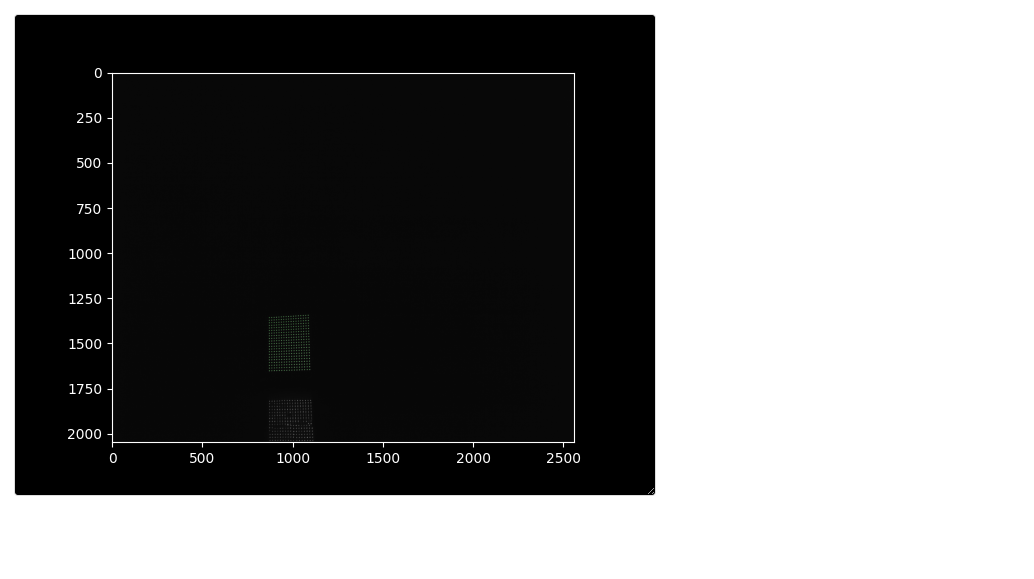

In [ ]:
# Run the detection
image_path = "/home/user/Dropbox/3DPTV_Illmenau/00000108_0000000018BA70F4.png"
rows = 21
cols = 17
grid_coords, output_img = detect_dot_grid(image_path, rows, cols)

_fig = plt.figure()
plt.imshow(output_img)
mo.mpl.interactive(_fig)